# Mushrooms Classification with ResNet50 and PSO

Notebook untuk menganalisis, melatih, dan menguji model klasifikasi jamur menggunakan transfer learning (ResNet50) dan hyperparameter tuning dengan PSO.

In [1]:
!python --version

Python 3.7.12


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import keras

print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.11.0
TensorFlow Hub version: 0.12.0
Keras version: 2.11.0


In [3]:
import os, random, shutil, pathlib
from IPython.display import clear_output
from tensorflow.keras.utils import image_dataset_from_directory
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np

original_dir = pathlib.Path('/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms')
new_base_dir = pathlib.Path('/kaggle/working/Mushrooms')
class_names = os.listdir('/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms')

In [4]:
print("Class Names:", class_names)

Class Names: ['Entoloma', 'Suillus', 'Hygrocybe', 'Agaricus', 'Amanita', 'Lactarius', 'Russula', 'Boletus', 'Cortinarius']


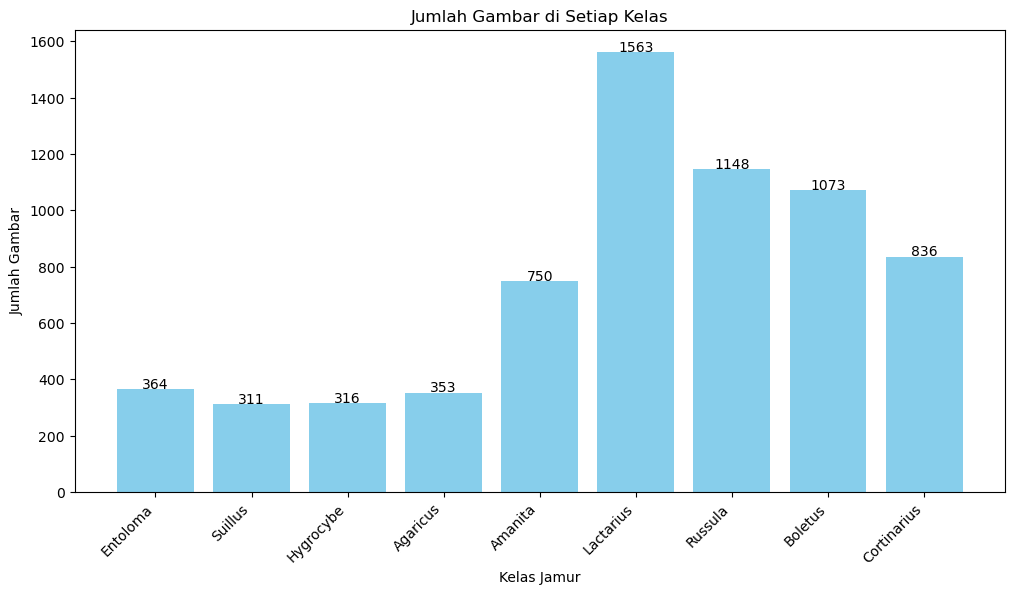

In [5]:
# Hitung jumlah gambar di setiap kelas
class_counts = [len(os.listdir(os.path.join(original_dir, class_name))) for class_name in class_names]

# Buat grafik batang
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts, color='skyblue')

# Tambahkan label dan judul
plt.xlabel("Kelas Jamur")
plt.ylabel("Jumlah Gambar")
plt.title("Jumlah Gambar di Setiap Kelas")
plt.xticks(rotation=45, ha="right")  # Putar label agar terbaca

# Tampilkan nilai di atas batang
for i, count in enumerate(class_counts):
    plt.text(i, count + 2, str(count), ha='center', fontsize=10)

# Tampilkan grafik
plt.show()


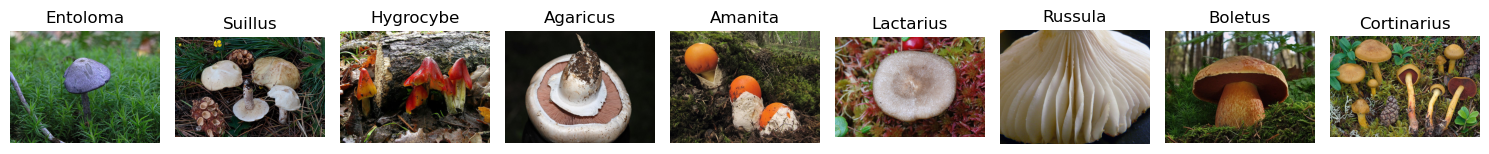

In [6]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Path ke dataset
original_dir = "/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms"

# Ambil daftar kelas
class_names = os.listdir(original_dir)

# Tentukan jumlah kelas yang akan ditampilkan
num_classes = len(class_names)

# Buat figure untuk menampilkan gambar
fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))

# Loop untuk menampilkan 1 gambar per kelas
for i, class_name in enumerate(class_names):
    class_path = os.path.join(original_dir, class_name)
    
    # Ambil satu gambar dari folder kelas tersebut
    image_name = os.listdir(class_path)[0]  # Ambil gambar pertama
    image_path = os.path.join(class_path, image_name)
    
    # Buka gambar
    img = Image.open(image_path)

    # Tampilkan gambar
    axes[i].imshow(img)
    axes[i].axis("off")  # Hilangkan axis
    axes[i].set_title(class_name)  # Set nama kelas sebagai judul

# Tampilkan semua gambar
plt.tight_layout()
plt.show()


In [7]:
# Global variables
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 100
PRETRAINED_MODEL_PATH = 'https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-classification/versions/2'
# PRETRAINED_MODEL_PATH = 'https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-classification/2'

In [12]:
import os
from pathlib import Path
import shutil
import numpy as np
from PIL import Image, ImageOps, ImageEnhance
import random

def random_augment(image):
    """
    Menerapkan augmentasi secara acak pada gambar PIL.
    Transformasi: rotasi, flip horizontal, penyesuaian kecerahan, kontras,
    zoom, shear, dan penyesuaian saturasi warna.
    Pastikan output berukuran (224, 224).
    """
    # Pastikan gambar RGB dan ukurannya 224x224
    image = image.convert("RGB").resize((224, 224), Image.BILINEAR)
    width, height = image.size
    
    # 1. Rotasi
    angle = random.uniform(-30, 30)
    image = image.rotate(angle, resample=Image.BILINEAR)
    
    # 2. Flip horizontal (50% kemungkinan)
    if random.random() < 0.5:
        image = ImageOps.mirror(image)
    
    # 3. Penyesuaian kecerahan
    brightness_enhancer = ImageEnhance.Brightness(image)
    brightness_factor = random.uniform(0.8, 1.2)
    image = brightness_enhancer.enhance(brightness_factor)
    
    # 4. Penyesuaian kontras
    contrast_enhancer = ImageEnhance.Contrast(image)
    contrast_factor = random.uniform(0.8, 1.2)
    image = contrast_enhancer.enhance(contrast_factor)
    
    # 5. Penyesuaian saturasi (warna)
    color_enhancer = ImageEnhance.Color(image)
    color_factor = random.uniform(0.8, 1.2)
    image = color_enhancer.enhance(color_factor)
    
    # 6. Zoom
    zoom_factor = random.uniform(0.8, 1.0)
    new_width, new_height = int(width * zoom_factor), int(height * zoom_factor)
    left = random.randint(0, width - new_width)
    top = random.randint(0, height - new_height)
    image = image.crop((left, top, left + new_width, top + new_height))
    image = image.resize((224, 224), Image.BILINEAR)
    
    # 7. Shear
    shear = random.uniform(-0.2, 0.2)
    xshift = abs(shear) * width
    new_width = width + int(round(xshift))
    image = image.transform((new_width, height), Image.AFFINE,
                            (1, shear, -xshift if shear > 0 else 0, 0, 1, 0),
                            resample=Image.BILINEAR)
    
    # Resize kembali ke ukuran 224x224
    image = image.resize((224, 224), Image.BILINEAR)
    
    return image

# -------------------------------------------
# Persiapan Folder Target
# -------------------------------------------
original_dir = Path('/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms')
new_base_dir = Path('/kaggle/working/Mushrooms')

# Bersihkan folder target jika sudah ada
if new_base_dir.exists():
    shutil.rmtree(new_base_dir)
new_base_dir.mkdir(parents=True, exist_ok=True)

# -------------------------------------------
# Proses Resampling dan Augmentasi
# -------------------------------------------
class_names = os.listdir(original_dir)
max_samples = 800  # Target jumlah gambar per kelas

for mushroom in class_names:
    class_dir_orig = original_dir / mushroom
    class_dir_new = new_base_dir / mushroom
    os.makedirs(class_dir_new, exist_ok=True)

    # Ambil daftar gambar asli dalam kelas
    original_fnames = os.listdir(class_dir_orig)
    if not original_fnames:
        continue  # Lewati kelas kosong

    # Jika jumlah gambar asli > target, lakukan undersampling
    if len(original_fnames) > max_samples:
        original_fnames = random.sample(original_fnames, k=max_samples)
    
    # Salin gambar asli ke folder target
    copied_fnames = []  # Simpan nama file yang berhasil disalin
    for fname in original_fnames:
        src_path = class_dir_orig / fname
        dst_path = class_dir_new / fname
        try:
            image = Image.open(src_path).convert("RGB").resize((224, 224), Image.BILINEAR)
            image.save(dst_path)
            copied_fnames.append(fname)
        except Exception as e:
            print(f"Error saat menyalin atau meresize file {src_path}: {e}")
            continue
    
    # Lakukan augmentasi untuk SEMUA gambar asli yang telah disalin
    # (Misalnya, satu salinan augmented per gambar asli)
    for fname in copied_fnames:
        image_path = class_dir_new / fname
        try:
            image = Image.open(image_path).convert("RGB").resize((224, 224), Image.BILINEAR)
            aug_image = random_augment(image)
            aug_fname = f"aug_{fname}"
            aug_path = class_dir_new / aug_fname
            aug_image.save(aug_path)
        except Exception as e:
            print(f"Error saat augmentasi {image_path}: {e}")
            continue
    
    # Setelah menyalin dan augmentasi, total gambar = (gambar asli) + (augmented)
    all_files = os.listdir(class_dir_new)
    total_files = len(all_files)
    print(f"Sebelum final sampling, kelas {mushroom} memiliki {total_files} gambar.")
    
    # Lakukan final sampling untuk memastikan total gambar tepat sama dengan target.
    # Jika jumlah file > target, lakukan undersampling; jika kurang, lakukan oversampling.
    if total_files > max_samples:
        # Ambil random sample dari file yang ada hingga mencapai max_samples
        selected = random.sample(all_files, k=max_samples)
        # Hapus file yang tidak dipilih
        for f in all_files:
            if f not in selected:
                os.remove(class_dir_new / f)
    elif total_files < max_samples:
        # Oversampling tambahan: buat augmented copy tambahan hingga mencapai target
        while len(os.listdir(class_dir_new)) < max_samples:
            fname = random.choice(copied_fnames)
            image_path = class_dir_new / fname
            try:
                image = Image.open(image_path).convert("RGB").resize((224, 224), Image.BILINEAR)
                aug_image = random_augment(image)
                new_fname = f"extra_{len(os.listdir(class_dir_new))}_{fname}"
                aug_path = class_dir_new / new_fname
                aug_image.save(aug_path)
            except Exception as e:
                print(f"Error saat oversampling {image_path}: {e}")
                continue
    
    final_count = len(os.listdir(class_dir_new))
    print(f"Kelas {mushroom}: {final_count} gambar (target: {max_samples})")

print("\nHybrid Resampling selesai! Semua kelas memiliki jumlah gambar yang tepat.")
import os
import math
import shutil
import random
from pathlib import Path
from PIL import Image, ImageOps, ImageEnhance

# Asumsi: variabel original_dir, new_base_dir, class_names, dan max_samples sudah didefinisikan sebagaimana di kode Anda sebelumnya.

# -------------------------------------------
# Membuat Direktori Validasi: data_val_dir
# -------------------------------------------
data_val_dir = Path('/kaggle/working/MushroomValidation')
if data_val_dir.exists():
    shutil.rmtree(data_val_dir)
data_val_dir.mkdir(parents=True, exist_ok=True)

# Menentukan target jumlah gambar validasi per kelas (rasio 9:1, artinya validasi = ~10% dari total)
target_val_samples = math.ceil(max_samples / 9)
print(f"Target gambar validasi per kelas: {target_val_samples}")

# Proses untuk tiap kelas
for mushroom in class_names:
    # Membuat folder untuk kelas di data_val_dir
    class_val_dir = data_val_dir / mushroom
    os.makedirs(class_val_dir, exist_ok=True)
    
    # Ambil daftar gambar asli dari original_dir untuk kelas ini
    class_dir_orig = original_dir / mushroom
    original_fnames = os.listdir(class_dir_orig)
    
    if not original_fnames:
        print(f"Tidak ada gambar pada kelas {mushroom} di {class_dir_orig}")
        continue
    
    # Pilih gambar sesuai target
    if len(original_fnames) > target_val_samples:
        # Undersampling: ambil sample acak sebanyak target_val_samples
        selected_val_fnames = random.sample(original_fnames, k=target_val_samples)
    elif len(original_fnames) < target_val_samples:
        # Oversampling: salin semua gambar, kemudian duplikasi secara acak hingga mencapai target
        selected_val_fnames = original_fnames.copy()
        while len(selected_val_fnames) < target_val_samples:
            selected_val_fnames.append(random.choice(original_fnames))
    else:
        selected_val_fnames = original_fnames
    
    # Salin gambar ke data_val_dir tanpa augmentasi, dengan resize ke 224x224
    for fname in selected_val_fnames:
        src_path = class_dir_orig / fname
        dst_path = class_val_dir / fname
        try:
            image = Image.open(src_path).convert("RGB").resize((224, 224), Image.BILINEAR)
            image.save(dst_path)
        except Exception as e:
            print(f"Error saat memproses gambar validasi {src_path}: {e}")
            continue
    
    final_val_count = len(os.listdir(class_val_dir))
    print(f"Kelas {mushroom}: {final_val_count} gambar untuk validasi (target: {target_val_samples})")

print("\nProses pembuatan data validasi selesai!")


Sebelum final sampling, kelas Entoloma memiliki 728 gambar.
Kelas Entoloma: 800 gambar (target: 800)
Sebelum final sampling, kelas Suillus memiliki 622 gambar.
Kelas Suillus: 800 gambar (target: 800)
Sebelum final sampling, kelas Hygrocybe memiliki 632 gambar.
Kelas Hygrocybe: 800 gambar (target: 800)
Sebelum final sampling, kelas Agaricus memiliki 706 gambar.
Kelas Agaricus: 800 gambar (target: 800)
Sebelum final sampling, kelas Amanita memiliki 1500 gambar.
Kelas Amanita: 800 gambar (target: 800)
Sebelum final sampling, kelas Lactarius memiliki 1600 gambar.
Kelas Lactarius: 800 gambar (target: 800)
Error saat menyalin atau meresize file /kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/Russula/092_43B354vYxm8.jpg: image file is truncated (95 bytes not processed)
Sebelum final sampling, kelas Russula memiliki 1598 gambar.
Kelas Russula: 800 gambar (target: 800)
Sebelum final sampling, kelas Boletus memiliki 1600 gambar.
Kelas Boletus: 800 gambar (target: 800)
Sebel

Contoh hasil augmentasi untuk kelas: Entoloma


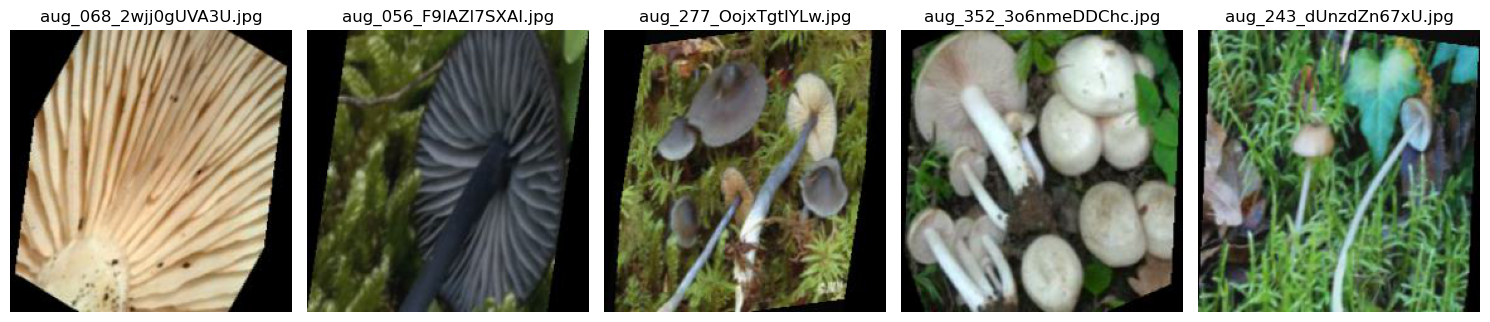

In [13]:
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan gambar hasil augmentasi
def plot_augmented_images(image_dir, num_images=5):
    # Ambil daftar file gambar dari direktori
    image_files = os.listdir(image_dir)
    
    # Filter hanya gambar yang memiliki nama depan "aug_"
    augmented_images = [f for f in image_files if f.startswith("aug_")]
    
    # Jika tidak ada gambar augmentasi, beri pesan
    if not augmented_images:
        print(f"Tidak ada gambar hasil augmentasi di direktori: {image_dir}")
        return
    
    # Pilih beberapa gambar secara acak dari gambar augmentasi
    selected_images = random.sample(augmented_images, min(num_images, len(augmented_images)))
    
    # Tampilkan gambar-gambar tersebut
    plt.figure(figsize=(15, 10))
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path)
        
        # Tampilkan gambar
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(img_name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Pilih satu kelas untuk ditampilkan contoh hasil augmentasi
example_class = class_names[0]  # Ambil kelas pertama sebagai contoh
example_dir = new_base_dir / example_class

# Tampilkan 5 gambar hasil augmentasi
print(f"Contoh hasil augmentasi untuk kelas: {example_class}")
plot_augmented_images(example_dir, num_images=5)

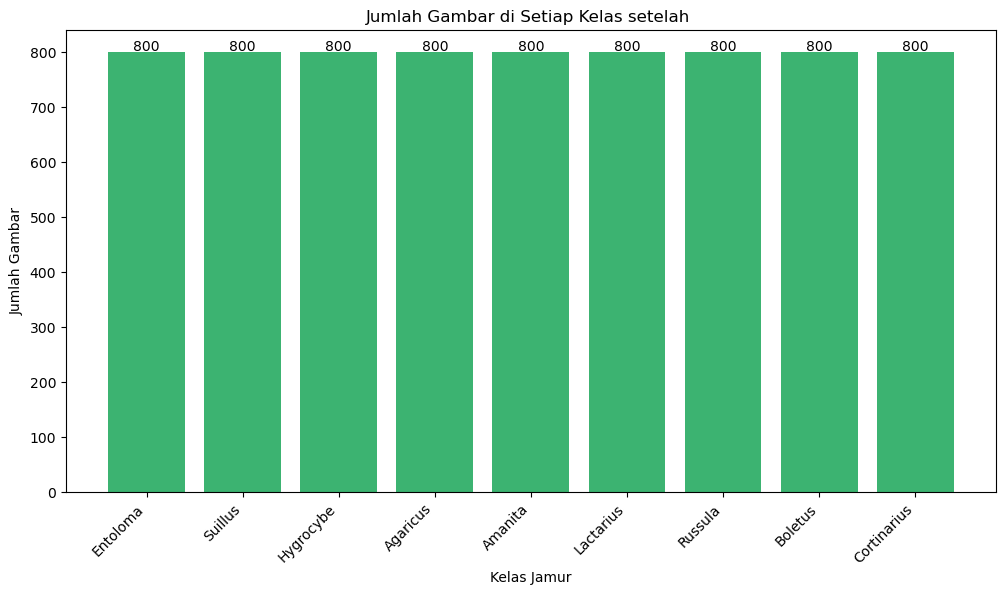

In [14]:
# Hitung jumlah gambar di setiap kelas
class_counts = [len(os.listdir(os.path.join(new_base_dir, class_name))) for class_name in class_names]

# Buat grafik batang
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts, color='mediumseagreen')

# Tambahkan label dan judul
plt.xlabel("Kelas Jamur")
plt.ylabel("Jumlah Gambar")
plt.title("Jumlah Gambar di Setiap Kelas setelah ")
plt.xticks(rotation=45, ha="right")  # Putar label agar terbaca

# Tampilkan nilai di atas batang
for i, count in enumerate(class_counts):
    plt.text(i, count + 2, str(count), ha='center', fontsize=10)

# Tampilkan grafik
plt.show()

In [17]:
train_ds = image_dataset_from_directory(
    new_base_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,  # Pastikan diaktifkan
    seed=33,
    # validation_split=0.1,
    # subset='training',
    interpolation='nearest')

val_ds = image_dataset_from_directory(
    # new_base_dir,
    data_val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,  # Ubah dari False menjadi True
    seed=33,
    # validation_split=0.1,
    # subset='validation',
    interpolation='nearest')


Found 7200 files belonging to 9 classes.
Found 801 files belonging to 9 classes.


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),          # Menambahkan variasi kontras
    layers.RandomTranslation(0.1, 0.1),    # Menambahkan translasi acak secara horizontal dan vertikal
    layers.Rescaling(1/255.)
])
normalization = layers.Rescaling(1/255.)

In [19]:
training_data = train_ds.map(lambda x,y: (data_augmentation(x), y)).prefetch(1).cache()
validation_data = val_ds.map(lambda x,y: (normalization(x), y)).prefetch(1).cache()                         

In [20]:
import numpy as np

# Hitung jumlah batch dan total gambar di setiap set
num_train_batches = tf.data.experimental.cardinality(train_ds).numpy()
num_val_batches = tf.data.experimental.cardinality(val_ds).numpy()

total_train_images = num_train_batches * BATCH_SIZE
total_val_images = num_val_batches * BATCH_SIZE

print(f"Total Training Images: {total_train_images}")
print(f"Total Validation Images: {total_val_images}")


Total Training Images: 7200
Total Validation Images: 832


In [21]:
import numpy as np
import tensorflow as tf

# Jumlah kelas
num_classes = len(class_names)

# Inisialisasi array untuk menghitung gambar per kelas
train_class_counts = np.zeros(num_classes, dtype=int)
val_class_counts = np.zeros(num_classes, dtype=int)

# Hitung jumlah gambar per kelas untuk training dataset
for images, labels in train_ds:
    # Label dalam mode 'categorical' berbentuk one-hot vector, jadi kita ambil argmax-nya
    label_indices = tf.argmax(labels, axis=1).numpy()
    for label in label_indices:
        train_class_counts[label] += 1

# Hitung jumlah gambar per kelas untuk validation dataset
for images, labels in val_ds:
    label_indices = tf.argmax(labels, axis=1).numpy()
    for label in label_indices:
        val_class_counts[label] += 1

# Tampilkan jumlah gambar per kelas untuk training
print("Jumlah Gambar per Kelas pada Training Data:")
for class_name, count in zip(class_names, train_class_counts):
    print(f"{class_name}: {count}")

# Tampilkan jumlah gambar per kelas untuk validasi
print("\nJumlah Gambar per Kelas pada Validation Data:")
for class_name, count in zip(class_names, val_class_counts):
    print(f"{class_name}: {count}")


Jumlah Gambar per Kelas pada Training Data:
Entoloma: 800
Suillus: 800
Hygrocybe: 800
Agaricus: 800
Amanita: 800
Lactarius: 800
Russula: 800
Boletus: 800
Cortinarius: 800

Jumlah Gambar per Kelas pada Validation Data:
Entoloma: 89
Suillus: 89
Hygrocybe: 89
Agaricus: 89
Amanita: 89
Lactarius: 89
Russula: 89
Boletus: 89
Cortinarius: 89


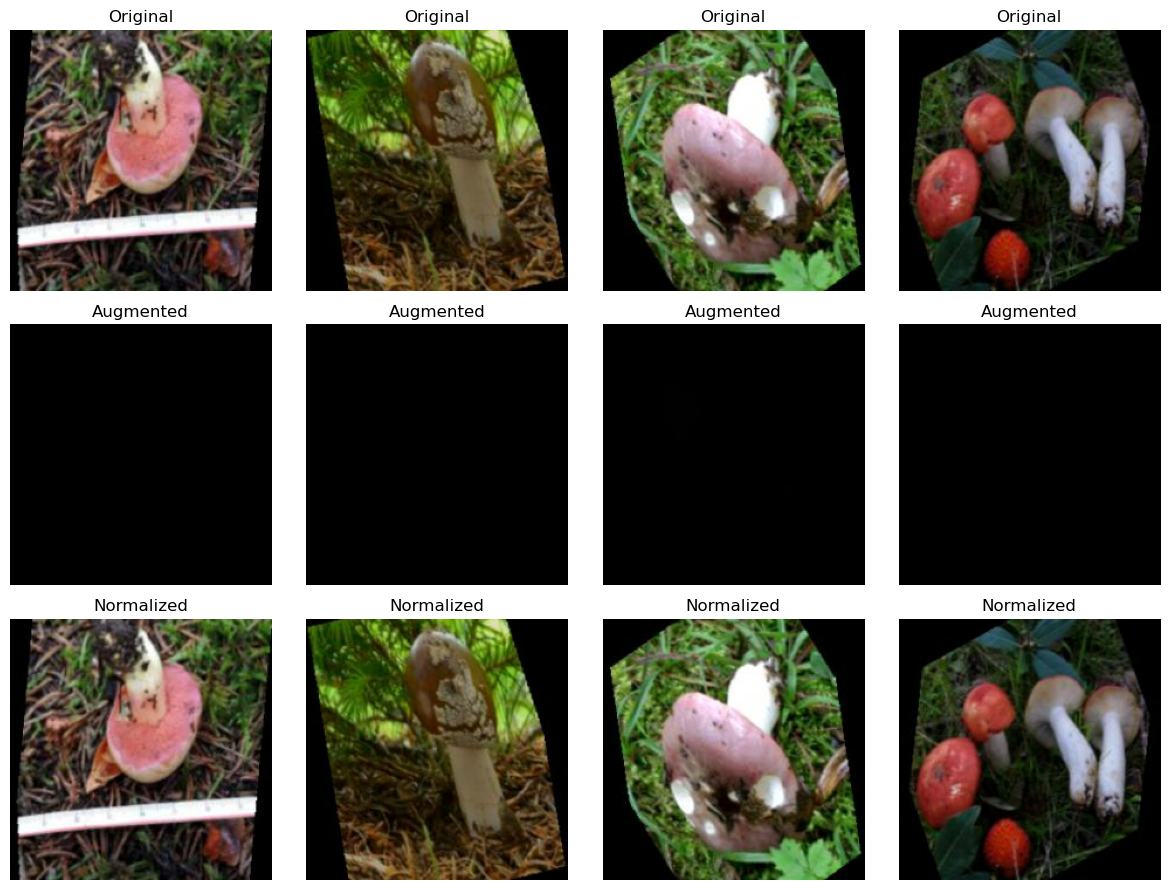

In [22]:
import matplotlib.pyplot as plt

# Ambil satu batch dari dataset training (gambar sebelum augmentasi)
for images, labels in train_ds.take(1):
    sample_images = images[:4]  # Ambil 4 gambar pertama

# Terapkan augmentasi pada gambar sample
augmented_images = data_augmentation(sample_images)

# Terapkan normalisasi pada gambar sample
normalized_images = normalization(sample_images)

# Plot gambar sebelum & sesudah augmentasi
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

for i in range(4):
    # Original image
    axes[0, i].imshow(sample_images[i].numpy().astype("uint8"))
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Augmented image
    axes[1, i].imshow(augmented_images[i].numpy().astype("uint8"))
    axes[1, i].axis("off")
    axes[1, i].set_title("Augmented")

    # Normalized image (perlu dikalikan 255 agar terlihat normal)
    axes[2, i].imshow((normalized_images[i].numpy() * 255).astype("uint8"))
    axes[2, i].axis("off")
    axes[2, i].set_title("Normalized")

plt.tight_layout()
plt.show()


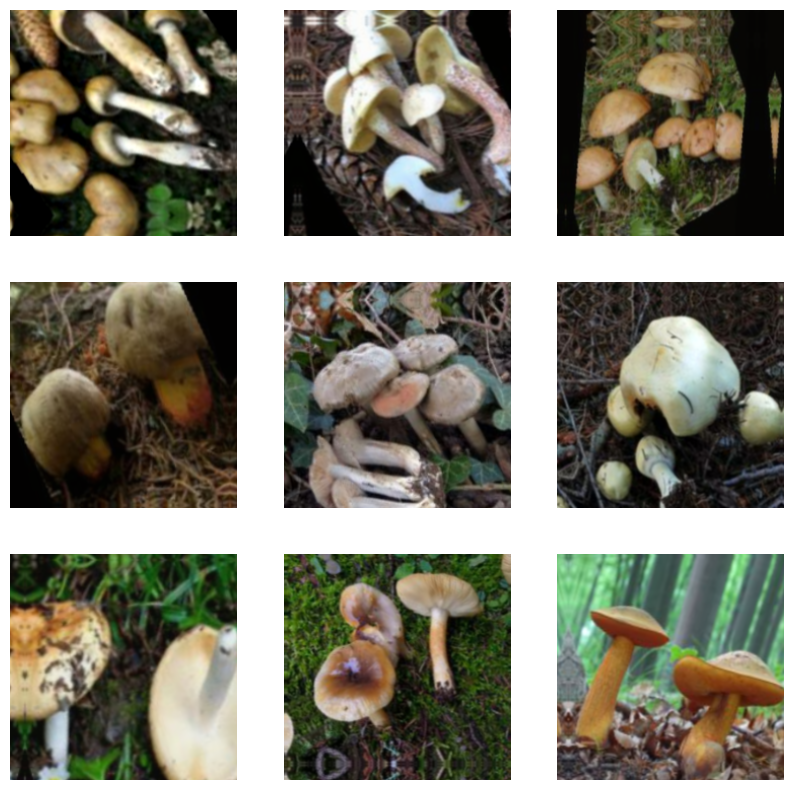

In [23]:
import matplotlib.pyplot as plt

# Ambil satu batch dari data training
for images, labels in training_data.take(1):
    plt.figure(figsize=(10, 10))
    
    # Tampilkan 9 gambar pertama di batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
    plt.show()


In [ ]:
!pip install pyswarms

In [25]:
import pyswarms as pso
from pyswarms.utils.functions import single_obj as fx
print("pyswarms version:", pso.__version__)

pyswarms version: 1.3.0


In [ ]:
keras_layer = hub.KerasLayer(PRETRAINED_MODEL_PATH)
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='weights.keras',
        save_best_only=True,
        # save_weights_only=True,
        monitor='val_accuracy',
        mode='max'
    )#,
    # tf.keras.callbacks.EarlyStopping(
    #     monitor='val_loss',  # Jika loss mulai meningkat, hentikan training
    #     patience=20,  # Tunggu 20 epoch sebelum benar-benar berhenti
    #     restore_best_weights=True
    # )
]


2025-04-30 04:41:21,201 - tensorflow - WARNING - Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.


In [28]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model
import pyswarms as ps
import numpy as np

def build_model(learning_rate, num_neurons, dropout_rate, fine_tune=False):
    inputs = layers.Input(shape=(224, 224, 3))
    x = keras_layer(inputs)  # Pretrained ResNet50 sebagai feature extractor
    
    # Jika fine_tuning diaktifkan, buka beberapa lapisan dari keras_layer
    if fine_tune:
        keras_layer.trainable = True  # atau set sebagian lapisan menjadi trainable
        # Misalnya, hanya melatih lapisan terakhir:
        for layer in keras_layer.layers[:-20]:
            layer.trainable = False
    else:
        keras_layer.trainable = False

    # Blok pertama dengan Batch Normalization
    x = layers.Dense(int(num_neurons), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # # Blok kedua (tambahan) dengan Batch Normalization
    # x = layers.Dense(int(num_neurons), activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(dropout_rate)(x)

    # Output layer untuk klasifikasi 9 kelas
    outputs = layers.Dense(9, activation='softmax')(x)

    model = Model(inputs, outputs)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [ ]:
def objective_function(params):
    # Ekstrak parameter dari setiap partikel PSO
    learning_rate, num_neurons, dropout_rate = params.T
    num_neurons = np.round(num_neurons).astype(int)  # Pastikan jumlah neuron integer
    num_samples = len(params)

    results = []
    for i in range(num_samples):
        # Selama PSO, fine-tuning non-aktif agar evaluasi cepat
        model = build_model(learning_rate[i], num_neurons[i], dropout_rate[i], fine_tune=False)
        history = model.fit(training_data, epochs=10, validation_data=validation_data, verbose=0)
        val_accuracy = history.history['val_accuracy'][-1]  # Ambil akurasi validasi epoch terakhir
        results.append(-val_accuracy)  # Karena PSO minimisasi
    return np.array(results)

# Definisikan batas parameter PSO
lb = [1e-6, 68, 0.2]   # Lower bounds: learning rate, neuron, dropout
ub = [1e-4, 300, 0.7]   # Upper bounds
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Inisialisasi dan jalankan PSO
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=3, options=options, bounds=(lb, ub))
best_cost, best_params = optimizer.optimize(objective_function, iters=5)
print(f"Best parameters found: {best_params}")



2025-04-30 04:41:23,884 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  80%|████████  |4/5, best_cost=-.694

In [ ]:
best_learning_rate, best_num_neurons, best_dropout_rate = best_params
best_num_neurons = int(best_num_neurons)  # Konversi ke integer

In [ ]:
# Bangun model ResNet50 dengan parameter terbaik
resnet50_model = build_model(best_learning_rate, best_num_neurons, best_dropout_rate)

# Lihat ringkasan arsitektur model
resnet50_model.summary()


In [ ]:
for layer in resnet50_model.layers:
    if isinstance(layer, tf.keras.layers.Dropout):
        print(f"Dropout rate: {layer.rate}")

In [ ]:
# Training model dengan fine-tuning diaktifkan dan epoch diperpanjang
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.keras',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max'
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=6,
    verbose=1,
    min_lr=1e-7
)
final_callbacks = [model_checkpoint, lr_scheduler]

history = resnet50_model.fit(
    training_data,
    validation_data=validation_data,
    epochs=150,
    callbacks=final_callbacks
)

In [ ]:
import matplotlib.pyplot as plt

# Ambil nilai history dari training
history_dict = history.history

# Cari akurasi tertinggi
max_train_acc = max(history_dict['accuracy'])
max_val_acc = max(history_dict['val_accuracy'])

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss', color='blue')
plt.plot(history_dict['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f"Training & Validation Accuracy\nMax Train: {max_train_acc:.4f}, Max Val: {max_val_acc:.4f}")
plt.legend()

plt.show()

# Tampilkan akurasi tertinggi di output terminal
print(f"\n🔹 Akurasi Tertinggi:")
print(f"✅ Training Accuracy Tertinggi: {max_train_acc:.4f}")
print(f"✅ Validation Accuracy Tertinggi: {max_val_acc:.4f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Dapatkan prediksi dari model pada data uji
y_pred = resnet50_model.predict(validation_data)
y_pred_classes = np.argmax(y_pred, axis=1)  # Ubah probabilitas ke kelas

# Jika test_data berupa tf.data.Dataset, kumpulkan label sebenarnya:
y_true = []
for x_batch, y_batch in validation_data:
    y_true.extend(np.argmax(y_batch, axis=1))
y_true = np.array(y_true)

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Cetak classification report untuk metrik per kelas
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


In [ ]:
!pip install -q streamlit